## 1. Importando as bibliotecas


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc)


## 2. Leitura dos dados

In [10]:
caminho_dados = '../Dados_Treino_Teste'

X_treino = pd.read_csv(f'{caminho_dados}/X_treino.csv')
X_teste = pd.read_csv(f'{caminho_dados}/X_teste.csv')
y_treino = pd.read_csv(f'{caminho_dados}/y_treino.csv').squeeze()
y_teste = pd.read_csv(f'{caminho_dados}/y_teste.csv').squeeze()

## 3. Treinando o modelo XGBoost

In [11]:
# Treinando o modelo com os dados de treino
modelo_xgb = XGBClassifier(eval_metric='logloss')
modelo_xgb.fit(X_treino, y_treino)


# Fazendo previsões no conjunto de teste
y_pred_teste = modelo_xgb.predict(X_teste)

# Calculando as métricas
print("Avaliação no Conjunto de Teste:")
print(f"Acurácia:  {accuracy_score(y_teste, y_pred_teste):.4f}")
print(f"Precisão:  {precision_score(y_teste, y_pred_teste):.4f}")
print(f"Recall:    {recall_score(y_teste, y_pred_teste):.4f}")
print(f"F1-score:  {f1_score(y_teste, y_pred_teste):.4f}")

Avaliação no Conjunto de Teste:
Acurácia:  0.9998
Precisão:  1.0000
Recall:    0.9997
F1-score:  0.9998


## 4. Matriz de Confusão 

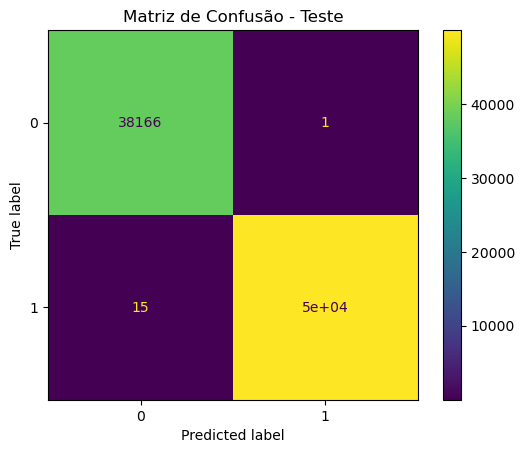

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

matriz_confusao = confusion_matrix(y_teste, y_pred_teste)
disp = ConfusionMatrixDisplay(confusion_matrix=matriz_confusao)
disp.plot()
plt.title("Matriz de Confusão - Teste")
plt.show()

## 5. Curva ROC

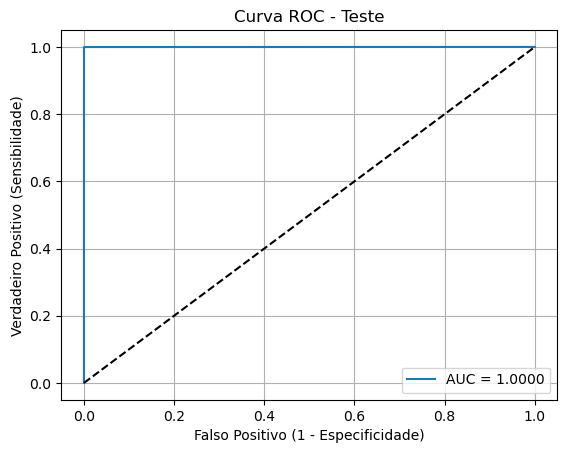

In [13]:
# Probabilidades para classe positiva
y_proba = modelo_xgb.predict_proba(X_teste)[:, 1]

# Curva ROC
fpr, tpr, _ = roc_curve(y_teste, y_proba)
roc_auc = auc(fpr, tpr)

# Plot
plt.figure()
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('Falso Positivo (1 - Especificidade)')
plt.ylabel('Verdadeiro Positivo (Sensibilidade)')
plt.title('Curva ROC - Teste')
plt.legend()
plt.grid()
plt.show()

##  Previsão de quantidades (cancelamentos e não cancelamentos)

In [14]:
quantidade_cancelamentos = np.sum(y_pred_teste == 1)
quantidade_nao_cancelamentos = np.sum(y_pred_teste == 0)

print(f"Quantidade prevista de cancelamentos: {quantidade_cancelamentos}")
print(f"Quantidade prevista de não cancelamentos: {quantidade_nao_cancelamentos}")


Quantidade prevista de cancelamentos: 49986
Quantidade prevista de não cancelamentos: 38181


## 6. Validação cruzada com multiplas métricas

In [15]:
# Concatenando os dados
X_total = pd.concat([X_treino, X_teste])
y_total = pd.concat([y_treino, y_teste])

# Métricas a validar
metricas = ['accuracy', 'precision', 'recall', 'f1']

# Validação cruzada
resultados_cv = cross_validate(
    modelo_xgb,
    X_total,
    y_total,
    cv=5,
    scoring=metricas
)

# Mostrando resultados
import pandas as pd

df_resultados = pd.DataFrame({
    'Métrica': [],
    'Média': [],
    'Desvio Padrão': []
})

for metrica in metricas:
    valores = resultados_cv[f'test_{metrica}']
    df_resultados = pd.concat([
        df_resultados,
        pd.DataFrame({
            'Métrica': [metrica],
            'Média': [f'{np.mean(valores):.4f}'],
            'Desvio Padrão': [f'{np.std(valores):.4f}']
        })
    ], ignore_index=True)

print(df_resultados)

     Métrica   Média Desvio Padrão
0   accuracy  0.9999        0.0001
1  precision  1.0000        0.0000
2     recall  0.9998        0.0001
3         f1  0.9999        0.0001


## 7. Comparar Desempenho no Treino e Teste (Checar Overfitting)

In [16]:
# Avaliação no treino
y_pred_train = modelo_xgb.predict(X_treino)

print("Avaliação no Conjunto de TREINO:")
print(f"Acurácia:  {accuracy_score(y_treino, y_pred_train):.4f}")
print(f"Precisão:  {precision_score(y_treino, y_pred_train):.4f}")
print(f"Recall:    {recall_score(y_treino, y_pred_train):.4f}")
print(f"F1-score:  {f1_score(y_treino, y_pred_train):.4f}")

Avaliação no Conjunto de TREINO:
Acurácia:  1.0000
Precisão:  1.0000
Recall:    1.0000
F1-score:  1.0000


## Comentário sobre overfitting
 O modelo apresenta desempenho perfeito no conjunto de treino (100% em todas as métricas), o que pode indicar overfitting. No entanto, como os resultados no conjunto de teste também são extremamente altos, o modelo ainda generaliza muito bem para dados não vistos. Isso sugere que o overfitting, se presente, é mínimo e não compromete a performance preditiva.


## 8. Visualização da Importância das Variáveis (XGBoost)

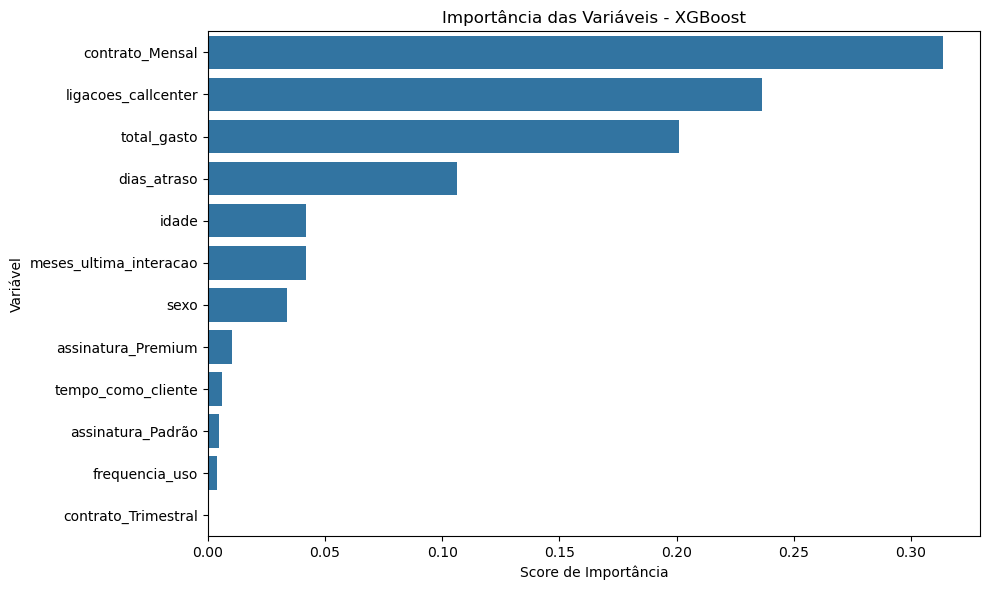

In [17]:
# Após treinar o modelo XGBoost, é importante visualizar quais variáveis mais influenciam as decisões.
# Isso pode ajudar a interpretar o modelo e identificar padrões importantes nos dados.

# Obtendo a importância das variáveis do modelo
importancias = modelo_xgb.feature_importances_

# Criando um DataFrame para exibição ordenada
df_importancia = pd.DataFrame({
    'Variável': X_treino.columns,
    'Importância': importancias
}).sort_values(by='Importância', ascending=False)

# Plotando o gráfico com Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Importância', y='Variável', data=df_importancia)
plt.title('Importância das Variáveis - XGBoost')
plt.xlabel('Score de Importância')
plt.ylabel('Variável')
plt.tight_layout()
plt.show()


<Figure size 1000x600 with 0 Axes>

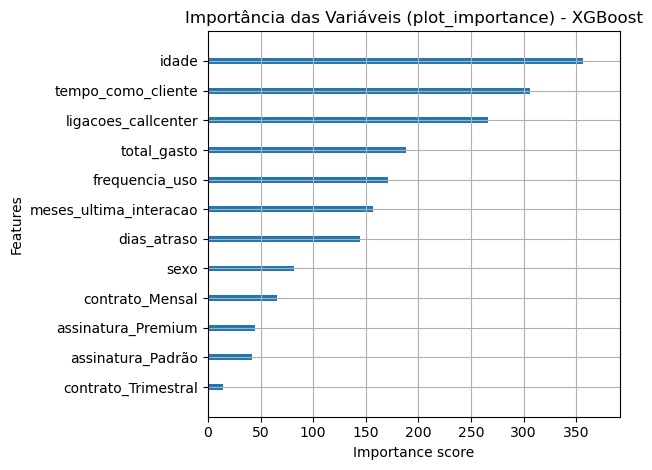

In [18]:
from xgboost import plot_importance

# Plotando a importância das variáveis diretamente com o XGBoost
plt.figure(figsize=(10, 6))
plot_importance(modelo_xgb, importance_type='weight', show_values=False)
plt.title('Importância das Variáveis (plot_importance) - XGBoost')
plt.tight_layout()
plt.show()

## 9. Salvando os Resultados das métricas

In [25]:
import time

# Medindo o tempo de treinamento
inicio = time.time()
modelo_xgb.fit(X_treino, y_treino)
fim = time.time()

# Tempo total em segundos
tempo_total = fim - inicio

# Convertendo para minutos e segundos
minutos, segundos = divmod(tempo_total, 60)
minutos = int(minutos)
segundos = round(segundos, 2)

# Fazendo previsões
y_pred_teste = modelo_xgb.predict(X_teste)
y_proba = modelo_xgb.predict_proba(X_teste)[:, 1]
roc_auc = roc_auc_score(y_teste, y_proba)

# Contagem de cancelamentos previstos
quantidade_cancelamentos = int(np.sum(y_pred_teste == 1))
quantidade_nao_cancelamentos = int(np.sum(y_pred_teste == 0))

# Valores reais no conjunto de teste
cancelamentos_reais = int(np.sum(y_teste == 1))
nao_cancelamentos_reais = int(np.sum(y_teste == 0))

# Dicionário de resultados
resultados_xgb = {
    'Acurácia': round(accuracy_score(y_teste, y_pred_teste), 4),
    'Precisão': round(precision_score(y_teste, y_pred_teste), 4),
    'Recall': round(recall_score(y_teste, y_pred_teste), 4),
    'F1-score': round(f1_score(y_teste, y_pred_teste), 4),
    'AUC': round(roc_auc, 4),
    'Cancelamentos previstos': quantidade_cancelamentos,
    'Cancelamentos reais': cancelamentos_reais,
    'Não cancelamentos previstos': quantidade_nao_cancelamentos,
    'Não cancelamentos reais': nao_cancelamentos_reais,
    'Tempo de treinamento': f'{minutos}m {segundos}s'
}

# Convertendo para DataFrame
df_resultados_xgb = pd.DataFrame.from_dict(resultados_xgb, orient='index', columns=['XGBoost'])

# Resultado
df_resultados_xgb.index.name = 'Métrica'
df_resultados_xgb = df_resultados_xgb.reset_index()

# Exibindo
print(df_resultados_xgb)

# Salvando como CSV
df_resultados_xgb.to_csv('resultados_xgboost.csv', index=False)
print("Arquivo 'resultados_xgboost.csv' salvo com sucesso.")


                       Métrica   XGBoost
0                     Acurácia    0.9998
1                     Precisão       1.0
2                       Recall    0.9997
3                     F1-score    0.9998
4                          AUC       1.0
5      Cancelamentos previstos     49986
6          Cancelamentos reais     50000
7  Não cancelamentos previstos     38181
8      Não cancelamentos reais     38167
9         Tempo de treinamento  0m 1.12s
Arquivo 'resultados_xgboost.csv' salvo com sucesso.


## Comentários sobre o resultado

Comparando as previsões do modelo com os valores reais no conjunto de teste
Observa-se que o modelo XGBoost apresentou excelente desempenho:
 - Foram previstos 49.986 cancelamentos, enquanto o valor real era 50.000.
 - Foram previstos 38.181 não cancelamentos, com valor real de 38.167.
Esses resultados indicam que o modelo possui alta capacidade de generalização, com mínima discrepância entre previsões e realidade.
A baixa diferença (apenas 14 casos em cada classe) reforça a confiabilidade do modelo, sendo corroborada pelas métricas elevadas de acurácia, precisão, recall e F1-score.
